In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Load data and see what we've got:

In [11]:
X_train = pd.read_csv('../input/X_train.csv')
Y_train = pd.read_csv('../input/y_train.csv')
X_pred = pd.read_csv('../input/X_test.csv')

In [12]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [13]:
Y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [14]:
X_pred.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


Let's aggregate data and take some aggregate statistics as features. I've chosen mean, max, min, sum and mean_abs_change also we need convert to euler angles:

In [15]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [16]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [17]:
X_train = fe_step0(X_train)
X_pred = fe_step0(X_pred)
print(X_train.shape)
X_train.head()

(487680, 19)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


In [18]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [19]:
X_train = fe_step1(X_train)
X_pred = fe_step1(X_pred)
print(X_train.shape)
X_train.head()

(487680, 22)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


In [20]:
def mean_abs_change(x):
    return np.mean(np.abs(np.diff(x)))

In [21]:
def get_features(df):
    result_df = pd.DataFrame()
    for col in df.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        result_df['{}_mean'.format(col)] = df.groupby(['series_id'])[col].mean()
        result_df['{}_max'.format(col)] = df.groupby(['series_id'])[col].max()
        result_df['{}_min'.format(col)] = df.groupby(['series_id'])[col].min()
        result_df['{}_sum'.format(col)] = df.groupby(['series_id'])[col].sum()
        result_df['{}_mean_abs_change'.format(col)] = df.groupby(['series_id'])[col].apply(mean_abs_change)
    return result_df

In [22]:
train_df = get_features(X_train)
pred_df = get_features(X_pred)

In [23]:
train_df = train_df.merge(Y_train, on='series_id', how='inner')

In [24]:
train_df.head()

,series_id,orientation_X_mean,orientation_X_max,orientation_X_min,orientation_X_sum,orientation_X_mean_abs_change,orientation_Y_mean,orientation_Y_max,orientation_Y_min,orientation_Y_sum,orientation_Y_mean_abs_change,orientation_Z_mean,orientation_Z_max,orientation_Z_min,orientation_Z_sum,orientation_Z_mean_abs_change,orientation_W_mean,orientation_W_max,orientation_W_min,orientation_W_sum,orientation_W_mean_abs_change,angular_velocity_X_mean,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_sum,angular_velocity_X_mean_abs_change,angular_velocity_Y_mean,angular_velocity_Y_max,angular_velocity_Y_min,angular_velocity_Y_sum,angular_velocity_Y_mean_abs_change,angular_velocity_Z_mean,angular_velocity_Z_max,angular_velocity_Z_min,angular_velocity_Z_sum,angular_velocity_Z_mean_abs_change,linear_acceleration_X_mean,linear_acceleration_X_max,linear_acceleration_X_min,linear_acceleration_X_sum,...,mod_quat_min,mod_quat_sum,mod_quat_mean_abs_change,norm_X_mean,norm_X_max,norm_X_min,norm_X_sum,norm_X_mean_abs_change,norm_Y_mean,norm_Y_max,norm_Y_min,norm_Y_sum,norm_Y_mean_abs_change,norm_Z_mean,norm_Z_max,norm_Z_min,norm_Z_sum,norm_Z_mean_abs_change,norm_W_mean,norm_W_max,norm_W_min,norm_W_sum,norm_W_mean_abs_change,euler_x_mean,euler_x_max,euler_x_min,euler_x_sum,euler_x_mean_abs_change,euler_y_mean,euler_y_max,euler_y_min,euler_y_sum,euler_y_mean_abs_change,euler_z_mean,euler_z_max,euler_z_min,euler_z_sum,euler_z_mean_abs_change,group_id,surface
0,0,-0.758666,-0.75822,-0.75953,-97.10922,0.000015,-0.634008,-0.63306,-0.63456,-81.15298,0.000018,-0.105474,-0.104610,-0.106140,-13.500690,0.000051,-0.106470,-0.105590,-0.107050,-13.628110,0.000042,-0.002481,0.107650,-0.16041,-0.317527,0.029984,-0.003306,0.072698,-0.079404,-0.423172,0.023222,0.007532,0.051720,-0.030181,0.964051,0.009186,0.263418,2.85380,-1.8644,33.717542,...,0.999993,128.000047,0.000004,-0.758666,-0.758219,-0.759527,-97.109184,0.000016,-0.634007,-0.633057,-0.634560,-81.152950,0.000018,-0.105474,-0.104610,-0.106140,-13.500685,0.000051,-0.106470,-0.105590,-0.107050,-13.628105,0.000042,2.841734,2.843933,2.840210,363.741945,0.000113,-0.025037,-0.023562,-0.025795,-3.204730,0.000065,1.396035,1.397395,1.393224,178.692438,0.000049,13,fine_concrete
1,1,-0.958606,-0.95837,-0.95896,-122.70162,0.000023,0.241867,0.24270,0.24074,30.95897,0.000070,0.031650,0.032341,0.030504,4.051239,0.000048,-0.146876,-0.145870,-0.148090,-18.800070,0.000103,0.004605,0.283420,-0.25480,0.589410,0.063036,-0.007757,0.112080,-0.134330,-0.992868,0.044310,0.006206,0.129150,-0.121610,0.794404,0.021542,0.121867,5.10020,-3.1934,15.599035,...,0.999994,128.000053,0.000004,-0.958606,-0.958368,-0.958960,-122.701569,0.000024,0.241867,0.242700,0.240740,30.958957,0.000070,0.031650,0.032341,0.030504,4.051237,0.000048,-0.146875,-0.145870,-0.148090,-18.800062,0.000103,2.840129,2.842328,2.837615,363.536497,0.000212,-0.010369,-0.009109,-0.012073,-1.327173,0.000087,-0.492730,-0.490164,-0.494641,-63.069490,0.000147,31,concrete
2,2,-0.512057,-0.50944,-0.51434,-65.54334,0.000041,-0.846171,-0.84490,-0.84779,-108.30988,0.000024,-0.129371,-0.128520,-0.130300,-16.559440,0.000059,-0.071082,-0.070378,-0.071535,-9.098478,0.000044,0.002646,0.141920,-0.15271,0.338645,0.029703,-0.009232,0.091946,-0.107810,-1.181655,0.035732,0.027989,0.088730,-0.015697,3.582611,0.013572,0.149711,1.85330,-2.5930,19.163063,...,0.999993,128.000015,0.000003,-0.512057,-0.509443,-0.514337,-65.543332,0.000041,-0.846171,-0.844896,-0.847794,-108.309868,0.000024,-0.129371,-0.128520,-0.130300,-16.559438,0.000059,-0.071082,-0.070378,-0.071535,-9.098477,0.000044,2.845528,2.847297,2.843556,364.227642,0.000134,-0.012195,-0.011795,-0.012734,-1.560956,0.000067,2.055021,2.061297,2.049675,263.042718,0.000097,20,concrete
3,3,-0.939169,-0.93884,-0.93968,-120.21364,0.000026,0.310140,0.31147,0.30943,39.69794,0.000036,0.038955,0.039799,0.037922,4.986241,0.000066,-0.142319,-0.139340,-0.144370,-18.216810,0.000195,0.000624,0.519130,-0.40152,0.079866,0.104522,-0.002804,0.1357

Now let's make some vizualisations of euler angles in connection of various types of surfaces:

In [25]:
surfaces = (train_df['surface'].value_counts()).index

In [26]:
features = []
for feature in train_df.columns.values[1:-2]:
    if 'euler' in feature:
        features.append(feature)

In [27]:
features

['euler_x_mean',
 'euler_x_max',
 'euler_x_min',
 'euler_x_sum',
 'euler_x_mean_abs_change',
 'euler_y_mean',
 'euler_y_max',
 'euler_y_min',
 'euler_y_sum',
 'euler_y_mean_abs_change',
 'euler_z_mean',
 'euler_z_max',
 'euler_z_min',
 'euler_z_sum',
 'euler_z_mean_abs_change']

In [28]:
def plot_features_and_surfaces(features, surfaces, train_df):
    i = 0
    plt.figure()
    fig, ax = plt.subplots(5,3,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(5,3,i)
        for surface in surfaces:
            ttc = train_df[train_df['surface']==surface]
            sns.kdeplot(ttc[feature], bw=0.5,label=surface)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

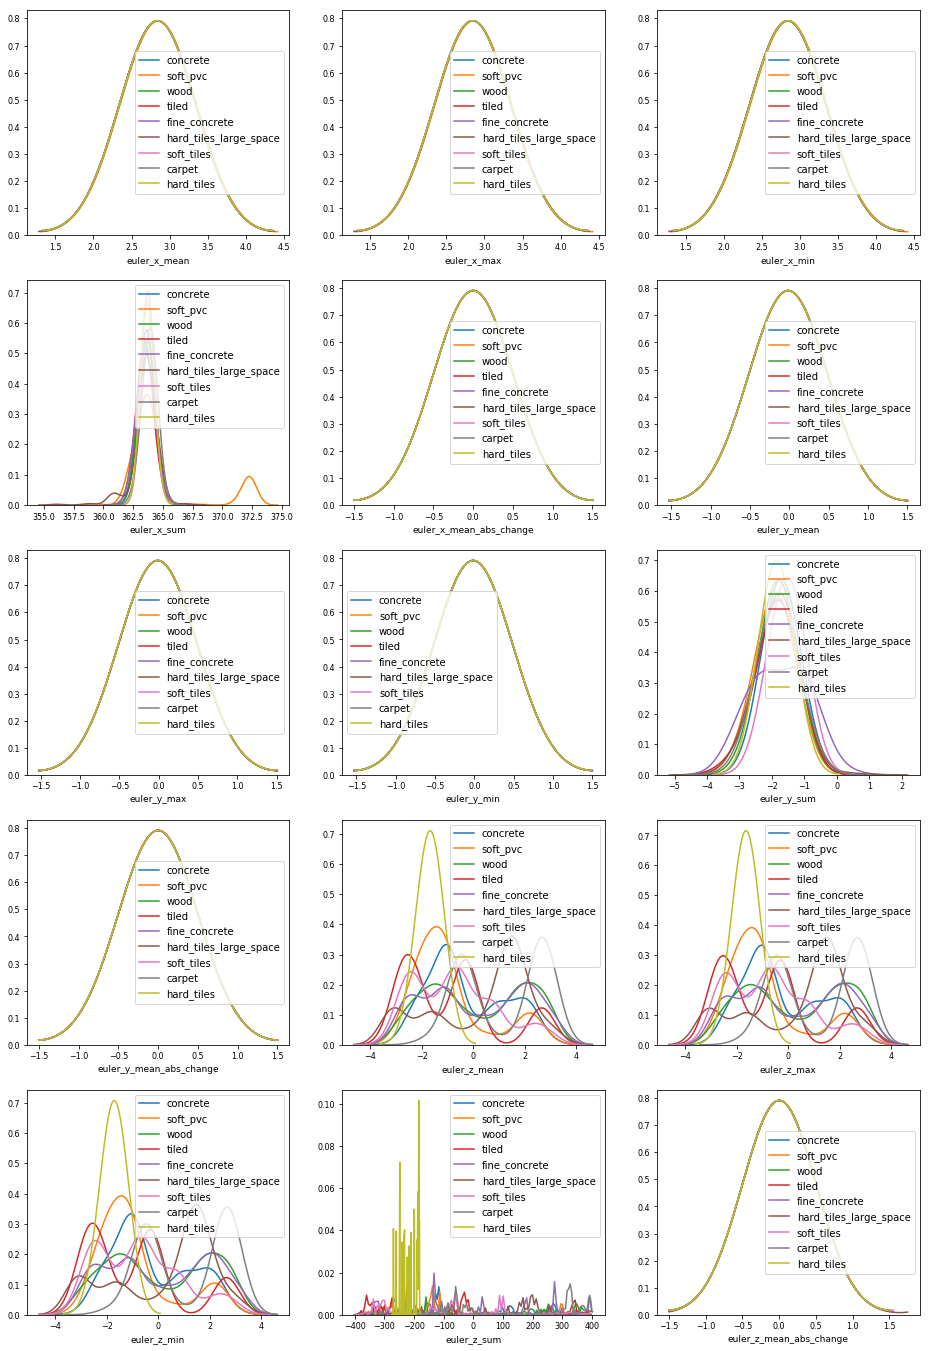

In [29]:
plot_features_and_surfaces(features, surfaces, train_df)

We can see that not all features provide clean separation of classes: particulary interesting are euler_z_mean, euler_z_max, euler_z_min.

## Prepare data for modeling:

### Encode our labels:


In [30]:
label_encoder = LabelEncoder()
train_df['surface'] = label_encoder.fit_transform(train_df['surface'])

In [31]:
train_df.drop(['series_id', 'group_id'], axis=1, inplace=True)

In [32]:
X = train_df.drop('surface', axis=1)
y = train_df['surface']

In [33]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)

## Cross validation:

In [34]:
def evaluate_model(model, X, y):
    score = cross_val_score(rf, X, y, cv=6)
    print(score)
    print(score.mean())

In [35]:
evaluate_model(rf, X, y)

[0.84976526 0.86050157 0.92464678 0.89889415 0.89240506 0.90966719]
0.8893133367403117


Nice accuracy on validation but LB will be significally lower - around 0.67.

In [38]:
def predict_and_submit(model, X, y, x_pred, label_encoder, file_name):
    model.fit(X, y)
    predictions = label_encoder.inverse_transform(model.predict(x_pred))
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['surface'] = predictions
    submission.to_csv(file_name, index=False)

In [39]:
predict_and_submit(rf, X, y, pred_df, label_encoder, 'submitWithEulers01.csv')

# References:
https://www.kaggle.com/jesucristo/1-robots-eda-rf-cval-0-73/notebook